In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import sklearn
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('../')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [3]:
### choose if you want to do only the 45 validation glaciers
validation_only = 1

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

### get list of all the glaciers for which we have calculated the snow covered fractions
# select which rgis to analyze
if validation_only:
    folder_ela = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation', 'ELAs')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_sca = os.path.join(folder_AGVA, 'Derived products', 'S2', 'ELAs')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# load rgi names that have been saved to the classified folder
rgis_to_analyze = list(set( [ i[:14] for i in os.listdir(folder_ela) if i!='merged.vrt' ] ))
# rgis_to_analyze.sort()

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))
# print(rgis_to_analyze[:10])
# print(rgis_to_analyze_df[:10])

45


In [4]:
skip = 0
for i in range(len(rgis_to_analyze)):
#     if i!=0: continue
    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]
#     if rgiid!='RGI60-01.15731': continue
        
    rgiid = rgis_to_analyze[i]
    # check if we've already run this glacier. if so, skip
    temp_path = os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
#     if os.path.exists(temp_path):
#         continue

    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area'].values[0]

#     if ga>300: continue
    
    # print progress
    print(f"\nStarting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga} km2")
    
    # open glacier mask
    glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgiid}_mask.nc"), chunks='auto').glacier
    
    # define the coarsen scale
    if ga>1000:
        scale=5
    elif ga>500:
        scale=3
        
    if ga>500:
        glacier_mask = glacier_mask.coarsen({"x":scale, "y":scale}, boundary="trim").median(skipna=True).astype('uint8')
        
    # open the ela dataframe
    path_open = os.path.join(folder_save, "ELAs", f"{rgiid}_ELAs.csv")
    ela_df = pd.read_csv(path_open)
    
#     print(ela_df)
    
    # throw out anything that has <XYZ% observed
    ela_df_good = ela_df[ela_df['observed_after_smoothing']>0.7]
    ela_df_good = ela_df_good[ela_df_good['observed_initial']>0.3]
    
    # now for each year, get the maximum ela
    annual_best = []
    
    bad_dates = []
    bad_elas = []
    expected_elas = []
    bad_dates2 = []
    bad_elas2 = []
    expected_elas2 = []
    
    for y in [2018,2019,2020,2021,2022]:
#         if y!=2020: continue
#         print(y)
        # decide which of the columns you are going to want to save
        cols_to_save = ['date', 'ela', 'observed_after_smoothing', 'aar', 'off_glacier']
        
        # subset to this year. note we only consider obs in the july-november time frame
        elas_this_year = ela_df_good[ (ela_df_good['date']>=f'{y}-07-01') & (ela_df_good['date']<f'{y}-12-01')].copy()
        
#         print(elas_this_year.shape)
        # add doy
        elas_this_year['date_dt'] = [datetime.strptime(i, "%Y-%m-%d") for i in elas_this_year['date'] ]
        elas_this_year['doy'] = [i.timetuple().tm_yday for i in elas_this_year['date_dt'] ]
        
        # if len=0, we have no good data so we save a null point
        n_obs = len(elas_this_year)
        if n_obs==0:
            annual_best.append(pd.Series({"date":f"{y}-01-01", "ela":-9999, 'fraction_observed':-9999, 'aar':-9999, 'off_glacier':-9999}))
        
        # else we decide which the best of the elas is and save that info
        else:
            
            ### filter out the ELA outliers
            for idx, row in elas_this_year.iterrows():
                
                # grab all obs in the 7-30 day preceding window
                # (due ot temporal smoothing we might have info being shared within past few days that we want to avoid)
                obs_past_30 = elas_this_year[ elas_this_year['doy'] >= (row['doy']-60) ]
                obs_past_30 = obs_past_30[ obs_past_30['doy'] < (row['doy']-1) ]

                # if there are no other obs in the past 30 days, we just need to trust that this is real
                if len(obs_past_30)<3:
                    continue

                else:
                    # line of best fit to these obs (predict ela from doy)
                    X = obs_past_30['doy'].values.reshape(-1, 1)
                    y = obs_past_30['ela']
                    y2 = obs_past_30['aar']
                    bestfit = LinearRegression().fit(X, y)

                    # predict the ela on this date from that fit
                    pred = bestfit.predict(np.array(row['doy']).reshape(-1, 1))

                    # calculate difference
                    ela_diff = row['ela']-pred
#                     print(f"Predicted:{pred} Observed:{ela_max_best['ela']}")

                    # if we within a reasonable range, then we say this is a good observation and save it
                    tolerance=200
                    if ela_diff<=tolerance:
                        continue
                    
                    # or if we predicted a negative slope, then all bets are off
                    elif bestfit.coef_[0]<0:
                        continue
                        
                    # of if the date range of all the obs used to predict are too tight, then we can't throw it out
                    elif (np.nanmax(obs_past_30['doy'])-np.nanmin(obs_past_30['doy']))<15:
                        continue

                    # otherwise, we remove this row because it's bad
                    else:
                        bad_dates.append(row['date'])
                        bad_elas.append(row['ela'])
                        expected_elas.append(pred)
                        elas_this_year.drop(idx, inplace=True) 
                   
                
                
            ### filter out the AAR outliers
            for idx, row in elas_this_year.iterrows():
                
                # grab all obs in the 7-30 day preceding window
                # (due ot temporal smoothing we might have info being shared within past few days that we want to avoid)
                obs_past_30 = elas_this_year[ elas_this_year['doy'] >= (row['doy']-60) ]
                obs_past_30 = obs_past_30[ obs_past_30['doy'] < (row['doy']-1) ]

                # if there are no other obs in the past 30 days, we just need to trust that this is real
                if len(obs_past_30)<3:
                    continue

                else:

                    # line of best fit to these obs (predict ela from doy)
                    X = obs_past_30['doy'].values.reshape(-1, 1)
                    y = obs_past_30['ela']
                    y2 = obs_past_30['aar']
                    bestfit = LinearRegression().fit(X, y2)

                    # predict the ela on this date from that fit
                    pred = bestfit.predict(np.array(row['doy']).reshape(-1, 1))

                    # calculate difference
                    aar_diff = row['aar']-pred
#                     print(f"Predicted:{pred} Observed:{ela_max_best['ela']}")

                    # if we within a reasonable range, then we say this is a good observation and save it
                    tolerance=-0.15
                    if aar_diff>=tolerance:
                        continue
                    
                    # or if we predicted a positive slope, then all bets are off
                    elif bestfit.coef_[0]>0:
                        continue
                        
                    # of if the date range of all the obs used to predict are too tight, then we can't throw it out
                    elif (np.nanmax(obs_past_30['doy'])-np.nanmin(obs_past_30['doy']))<10:
                        continue

                    # otherwise, we remove this row because it's bad
                    else:
                        bad_dates2.append(row['date'])
                        bad_elas2.append(row['aar'])
                        expected_elas2.append(pred)
                        elas_this_year.drop(idx, inplace=True) 
            
            # find the maximum ela
            ela_max = np.nanmax(elas_this_year['ela'])

            # get all the dates that had this ela
            ela_max_all = elas_this_year[elas_this_year['ela']==ela_max]

            # we'll take the one that has the minimum aar to be the 'best' estimate
            # for example, if the ela is well above the glacier, there are likely many dates with the same ela found
            ela_max_best = ela_max_all.loc[ela_max_all['aar'].idxmin()]
            
            # find the minimum aar
            aar_min = np.nanmin(elas_this_year['aar'])
            aar_min_all = elas_this_year[elas_this_year['aar']==aar_min]
            aar_min_best = aar_min_all.loc[aar_min_all['ela'].idxmax()]
            
            # choose which to use
            best = ela_max_best #ela_max_best, aar_min_best
            
            # save this data
            annual_best.append(best[cols_to_save])
            
    ### save all the data here
    
    # function to format metadata and attributes
    def format_xr_to_save(xr_da):
        xr_da.attrs["res"] = (10,10)
        xr_da.attrs["crs"] = "EPSG:3338"
        xr_da.attrs["transform"] = [10,0,0,0,-10,0]
        xr_da.attrs["_FillValue"] = 0
        xr_da.attrs["long_name"] = rgiid
        xr_da.attrs["description"] = "0: nan, 1: ablation, 2: accumulation"
        xr_da.name = "accumulation_area"

        xr_da.x.attrs["units"] = "meters"
        xr_da.y.attrs["units"] = "meters"
        xr_da.x.attrs["long_name"] = 'x'
        xr_da.y.attrs["long_name"] = 'y'

        return xr_da
    
    # set folder paths, etc...
    path_df_all = os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
    path_xr_all = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_2018_2022_annual_AAs.nc")
    path_xr_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.nc")
    path_tif_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.tif")
    
    # one year at a time, get the snow distributions
    all_maps = []
    for s in annual_best:
        
        # get date
        d = s['date']
        y = d[:4]
        
        # skip the null years
        if d[5:7]=='01': continue
        
        # open the snow distribution map
        if ga>500:
            path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_shadowed_coarse_smoothed.nc")
        else:
            path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_shadowed_smoothed.nc")
        
        snow = xr.open_dataset(path_open, chunks={'time':1})['class'].sel(time=d)
        
        # add to list to save
        all_maps.append(snow.copy())
        
        # save each as a tif
        path_out = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_{y}_AA.tif")
        snow = format_xr_to_save(snow)
        encoding = {"accumulation_area":{"zlib": True}}
        
        snow.rio.to_raster(raster_path=path_out, encoding=encoding)
    
    # format to save maps as long as there is usable imagery
    if len(all_maps)>0:
        
        # compute average map
        all_maps = xr.concat(all_maps, dim='time')
        all_maps = all_maps.where(all_maps.isin([1,2]), np.nan)
        average_map = all_maps.median('time', skipna=True).astype('uint8')#+glacier_mask
        
        save_xr_all = format_xr_to_save(all_maps.astype('uint8'))
        save_xr_avg = format_xr_to_save(average_map)

        # specify compression/encoding
        encoding = {"accumulation_area":{"zlib": True}}#, "spatial_ref":{"zlib": False}}
        # ['PREDICTOR=2','COMPRESS=DEFLATE', 'ZLEVEL=9'])
        
        # save
        save_xr_all.to_netcdf(path_xr_all, encoding=encoding)
#         save_xr_avg.to_netcdf(path_xr_avg, encoding=encoding)
        save_xr_avg.rio.to_raster(raster_path=path_tif_avg, encoding=encoding)

    # always save the csv
    annual_best = pd.DataFrame(annual_best)
    annual_best.to_csv(path_df_all, index=False) # table with annual end-of-summer ela, aar, date, fraction observed

print('All done!')


Starting 1 of 45: RGI60-01.10910  2.084 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 2 of 45: RGI60-01.00787  2.126 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 3 of 45: RGI60-01.23606  2.344 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 4 of 45: RGI60-01.15253  2.551 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 5 of 45: RGI60-01.03379  2.578 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 6 of 45: RGI60-01.16719  2.681 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 7 of 45: RGI60-01.17321  2.88 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 8 of 45: RGI60-01.13462  3.206 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 9 of 45: RGI60-01.13483  3.216 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 10 of 45: RGI60-01.02584  3.441 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 11 of 45: RGI60-01.03215  3.998 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 12 of 45: RGI60-01.01666  4.243 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 13 of 45: RGI60-01.12548  4.314 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 14 of 45: RGI60-01.13930  4.404 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 15 of 45: RGI60-01.09624  4.487 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 16 of 45: RGI60-01.15516  4.764 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 17 of 45: RGI60-01.21721  6.422 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 18 of 45: RGI60-01.10255  7.262 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 19 of 45: RGI60-01.12165  7.969 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 20 of 45: RGI60-01.05007  9.216 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 21 of 45: RGI60-01.01104  9.528 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 22 of 45: RGI60-01.12186  11.05 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 23 of 45: RGI60-01.09656  13.791 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 24 of 45: RGI60-01.17784  14.773 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 25 of 45: RGI60-01.14493  15.336 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 26 of 45: RGI60-01.23643  15.732 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 27 of 45: RGI60-01.01270  16.163 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 28 of 45: RGI60-01.09162  16.749 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 29 of 45: RGI60-01.05078  17.259 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 30 of 45: RGI60-01.00570  17.567 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 31 of 45: RGI60-01.00557  18.042 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 32 of 45: RGI60-01.09216  18.634 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 33 of 45: RGI60-01.26731  20.207 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 34 of 45: RGI60-01.00565  23.06 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 35 of 45: RGI60-01.08989  29.395 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 36 of 45: RGI60-01.16166  29.932 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 37 of 45: RGI60-01.15731  40.009 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 38 of 45: RGI60-01.09798  41.785 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 39 of 45: RGI60-01.01743  45.165 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 40 of 45: RGI60-01.15135  66.067 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 41 of 45: RGI60-01.19542  71.722 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 42 of 45: RGI60-01.20841  80.284 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 43 of 45: RGI60-01.03741  136.264 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 44 of 45: RGI60-01.16558  343.098 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Starting 45 of 45: RGI60-01.01390  521.396 km2


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


All done!


           date     ela  observed_after_smoothing     aar  off_glacier
28   2018-10-01  1420.0                    0.9862  0.5050        False
62   2019-09-09  1490.0                    0.9887  0.2791        False
88   2020-09-25  1170.0                    0.8680  0.7252        False
109  2021-09-18   990.0                    0.9308  0.8400        False
141  2022-09-18   950.0                    0.9576  0.8618        False


Text(0.5, 0.98, 'RGI60-01.01390')

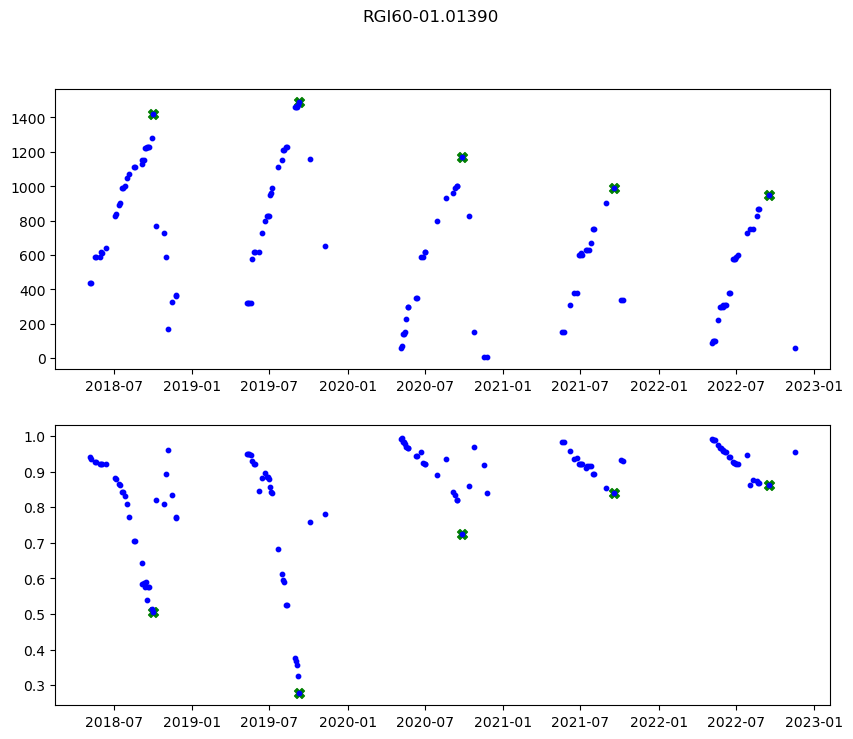

In [5]:
print(annual_best)
fig,axs = plt.subplots(2,1, figsize=(10,8))
marker = 'o'
size = 10
color='blue'
axs[0].scatter(pd.to_datetime(ela_df_good['date']), ela_df_good['ela'], marker=marker, s=size, c=color, zorder=5)
axs[1].scatter(pd.to_datetime(ela_df_good['date']), ela_df_good['aar'], marker=marker, s=size, c=color, zorder=5)

axs[0].scatter(pd.to_datetime(bad_dates), bad_elas, c='red')
axs[0].scatter(pd.to_datetime(bad_dates), expected_elas, c='orange')

axs[1].scatter(pd.to_datetime(bad_dates2), bad_elas2, c='red')
axs[1].scatter(pd.to_datetime(bad_dates2), expected_elas2, c='orange')
    
marker = 'X'
size = 50
color='green'
axs[0].scatter(pd.to_datetime(annual_best['date']), annual_best['ela'], marker=marker, s=size, c=color, zorder=1)
axs[1].scatter(pd.to_datetime(annual_best['date']), annual_best['aar'], marker=marker, s=size, c=color, zorder=1)

plt.suptitle(rgiid)